In [11]:
import os
import joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Activation, Bidirectional, Dropout, TimeDistributed, RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import accuracy_score, classification_report

np.random.seed(seed=17)

### Simulation Subset Selection
- Use the results summary file to select a subset of simulations for model training and testing
    - Randomly select n non-fail cases and n fail cases
    - Use the simulation ids to read in the corresponding simulation data files


In [2]:
# Import simulation results
results = pd.read_csv('processed_results_summary.csv', keep_default_na=False)
results.head()

,Unnamed: 0,Simulation no#,Line,Load,Wind1,Wind2,Wind3,flag,Sequence,n_failures,t_fail,t_first_fail,dt_fail,failed component_type,failed_component_type,cascade,fail
0,0,1,Line 04 - 05,0.7,0.0,0.0,0.0,0,[],0,,,,,,False,False
1,18,10,Line 26 - 28,0.7,0.0,0.0,0.0,0,[],0,,,,,,False,False
2,198,100,Line 09 - 39,0.7,0.0,0.0,0.4,0,[],0,,,,,,False,False
3,1998,1000,Line 22 - 23,0.7,0.0,0.8,1.0,0,[],0,,,,,,False,False
4,19998,10000,Line 10 - 11,0.8,0.4,0.2,0.0,0,[],0,,,,,,False,False


### Data Generator

- Create a data generator to read in training, validation and test data by batches
- Model input formats:  
    x -> (n_batch, n_time_steps, n_features)  
    y -> (n_batch, 1)

In [3]:
# List data files and read in the selected simulations
DATA_PATH = '/output/02_preprocessed_numpy'
files = os.listdir(DATA_PATH)

In [64]:
# Get the simulation ids of sims with and without failures
fail_ids = results[results['flag']==1]['Simulation no#'].tolist()
non_fail_ids = results[results['flag']==0]['Simulation no#'].tolist()

# Randomly select fail and non-fail ids
fail_ids = np.random.choice(fail_ids, size=len(fail_ids), replace=False)
non_fail_ids = np.random.choice(non_fail_ids, size=20000, replace=False)

# Get full filepaths
paths_fail, paths_non_fail = [], []
labels_fail, labels_non_fail = [], []

for file in files:
    file_id = int(file.split('.pkl')[0])

    if file_id in fail_ids and len(paths_fail) < 3500:
        paths_fail.append(os.path.join(DATA_PATH, file))
        labels_fail.append(1)

    if file_id in non_fail_ids and len(paths_non_fail) < 10000:
        paths_non_fail.append(os.path.join(DATA_PATH, file))
        labels_non_fail.append(0)

print(len(paths_fail), len(paths_non_fail))
train_paths, train_labels = paths_non_fail[:6000], labels_non_fail[:6000]
val_paths, val_labels = paths_non_fail[6000:6500], labels_non_fail[6000:6500]
test_paths, test_labels = paths_non_fail[6500:7000] + paths_fail[:500], labels_non_fail[6500:7000] + labels_fail[:500]

3500 10000


In [8]:
def train_val_generator(batch_size, filepaths, length, shift):
    """
    Yields model input and target output with shapes
    (batch_size, n_time_steps, n_features), (batch_size, n_time_steps, n_features)
    """
    count = 0
    X = []

    for file in filepaths:
        # Load simulation file as numpy array
        arr = joblib.load(os.path.join(DATA_PATH, file))

        # Windowing - create evenly sized samples
        end_index = arr.shape[0] - length

        for i in range(0, end_index, shift):
            X.append(arr[i:(i+length), 1:])
            count += 1

            if count >= batch_size:
                yield (np.array(X).astype(np.float32), np.array(X).astype(np.float32))
                X = []
                count = 0

In [9]:
def test_generator(batch_size, filepaths, labels, length, shift):
    count = 0
    X, y = [], []

    for file, label in zip(filepaths, labels):
        # Load simulation file as numpy array
        arr = joblib.load(os.path.join(DATA_PATH, file))

        # Windowing - create evenly sized samples
        end_index = arr.shape[0] - length

        for i in range(0, end_index, shift):
            y.append(int(label))
            X.append(arr[i:(i+length), 1:])
            count += 1

            if count >= batch_size:
                yield (np.array(X).astype(np.float32), np.array(y))
                X, y = [], []
                count = 0

### Model Training and Evaluation
- Train an autoencoder on samples with no failures
- Set a threshold based on the reconstruction loss statistics
- Evaluate on test data: accuracy, precision, recall, F1 score

In [32]:
# Autoencoder model
EPOCH_SIZE = 10

# Number of time steps and number of features
n_time_steps = 100
n_feats = 259


model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_time_steps, n_feats), return_sequences=True))
model.add(LSTM(10, activation='relu', return_sequences=True))
model.add(LSTM(4, activation='relu', return_sequences=False))
model.add(RepeatVector(n_time_steps))
model.add(LSTM(4, activation='relu', return_sequences=True))
model.add(LSTM(10, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_feats)))

adam = optimizers.Adam(lr=0.001, clipnorm=0.001)
model.compile(loss='mae', optimizer=adam)
model.summary()

# Start training
early_stop = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint(
    filepath='checkpoint',
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

history = model.fit_generator(
    train_val_generator(256, train_paths, 100, 25),
    validation_data=train_val_generator(256, val_paths, 100, 25),
    validation_steps=6,
    epochs=EPOCH_SIZE,
    steps_per_epoch=100,
    callbacks=[early_stop, checkpoint]
)

model.save('model')

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
unified_lstm_17 (UnifiedLSTM (None, 100, 50)           62000     
_________________________________________________________________
unified_lstm_18 (UnifiedLSTM (None, 100, 10)           2440      
_________________________________________________________________
unified_lstm_19 (UnifiedLSTM (None, 4)                 240       
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 100, 4)            0         
_________________________________________________________________
unified_lstm_20 (UnifiedLSTM (None, 100, 4)            144       
_________________________________________________________________
unified_lstm_21 (UnifiedLSTM (None, 100, 10)           600       
_________________________________________________________________
unified_lstm_22 (UnifiedLSTM (None, 100, 50)          

  1/100 [..............................] - ETA: 31:03 - loss: 5.6617

  2/100 [..............................] - ETA: 15:56 - loss: 3.8670

  3/100 [..............................] - ETA: 10:53 - loss: 3.0326

  4/100 [>.............................] - ETA: 8:21 - loss: 2.6824 

  5/100 [>.............................] - ETA: 6:49 - loss: 2.3839

  6/100 [>.............................] - ETA: 5:47 - loss: 2.1805

  7/100 [=>............................] - ETA: 5:03 - loss: 2.0362

  8/100 [=>............................] - ETA: 4:31 - loss: 1.9226

  9/100 [=>............................] - ETA: 4:05 - loss: 1.8380

 10/100 [==>...........................] - ETA: 3:44 - loss: 1.7661

 11/100 [==>...........................] - ETA: 3:27 - loss: 1.7096

 12/100 [==>...........................] - ETA: 3:12 - loss: 1.6627

 13/100 [==>...........................] - ETA: 3:00 - loss: 1.6226

 14/100 [===>..........................] - ETA: 2:49 - loss: 1.5879

 15/100 [===>..........................] - ETA: 2:40 - loss: 1.5605

 16/100 [===>..........................] - ETA: 2:32 - loss: 1.5357

 17/100 [====>.........................] - ETA: 2:24 - loss: 1.5697

 18/100 [====>.........................] - ETA: 2:17 - loss: 1.5469

 19/100 [====>.........................] - ETA: 2:11 - loss: 1.5264

 20/100 [=====>........................] - ETA: 2:06 - loss: 1.5085

 21/100 [=====>........................] - ETA: 2:01 - loss: 1.4905

 22/100 [=====>........................] - ETA: 1:57 - loss: 1.4744

 23/100 [=====>........................] - ETA: 1:52 - loss: 1.4599

 24/100 [======>.......................] - ETA: 1:48 - loss: 1.4461

 25/100 [======>.......................] - ETA: 1:45 - loss: 1.4337

 26/100 [======>.......................] - ETA: 1:41 - loss: 1.4216

 27/100 [=======>......................] - ETA: 1:38 - loss: 1.4109

 28/100 [=======>......................] - ETA: 1:35 - loss: 1.4024

 29/100 [=======>......................] - ETA: 1:32 - loss: 1.3949

 30/100 [========>.....................] - ETA: 1:29 - loss: 1.3862

 31/100 [========>.....................] - ETA: 1:27 - loss: 1.3784

 32/100 [========>.....................] - ETA: 1:24 - loss: 1.3705

 33/100 [========>.....................] - ETA: 1:22 - loss: 1.3630

 34/100 [=========>....................] - ETA: 1:19 - loss: 1.3556

 35/100 [=========>....................] - ETA: 1:17 - loss: 1.3481

 36/100 [=========>....................] - ETA: 1:15 - loss: 1.3409

 37/100 [==========>...................] - ETA: 1:13 - loss: 1.3339

 38/100 [==========>...................] - ETA: 1:11 - loss: 1.3270

 39/100 [==========>...................] - ETA: 1:09 - loss: 1.3192

 40/100 [===========>..................] - ETA: 1:07 - loss: 1.3108

 41/100 [===========>..................] - ETA: 1:05 - loss: 1.3979

 42/100 [===========>..................] - ETA: 1:04 - loss: 2.8322

 43/100 [===========>..................] - ETA: 1:02 - loss: 4.1123

 44/100 [============>.................] - ETA: 1:00 - loss: 6.2969

 45/100 [============>.................] - ETA: 59s - loss: 9.7230 

 46/100 [============>.................] - ETA: 57s - loss: 13.6315

 47/100 [=============>................] - ETA: 56s - loss: 39.2618

 48/100 [=============>................] - ETA: 54s - loss: 58.0622

 49/100 [=============>................] - ETA: 53s - loss: 85.5428

 50/100 [==============>...............] - ETA: 51s - loss: 264.1458

 51/100 [==============>...............] - ETA: 50s - loss: 410.6754

 52/100 [==============>...............] - ETA: 48s - loss: 1952.9655

 53/100 [==============>...............] - ETA: 47s - loss: 2132.9588

 54/100 [===============>..............] - ETA: 46s - loss: 2344.2580

 55/100 [===============>..............] - ETA: 45s - loss: 2582.0271

 56/100 [===============>..............] - ETA: 43s - loss: 9496.8068

 57/100 [================>.............] - ETA: 42s - loss: 12398.5018

 58/100 [================>.............] - ETA: 41s - loss: 14904.0605

 59/100 [================>.............] - ETA: 40s - loss: 15104.7055

 60/100 [=================>............] - ETA: 38s - loss: 15678.2393

 61/100 [=================>............] - ETA: 37s - loss: 16147.1610

 62/100 [=================>............] - ETA: 36s - loss: 16585.5904

 63/100 [=================>............] - ETA: 35s - loss: 18237.6274

 64/100 [==================>...........] - ETA: 34s - loss: 18569.6456

 65/100 [==================>...........] - ETA: 33s - loss: 20320.0905

 66/100 [==================>...........] - ETA: 32s - loss: 20414.6140

 67/100 [===================>..........] - ETA: 31s - loss: 20587.3105

 68/100 [===================>..........] - ETA: 30s - loss: 20391.5225

 69/100 [===================>..........] - ETA: 29s - loss: 20226.9475

 70/100 [====================>.........] - ETA: 27s - loss: 20090.7471

 71/100 [====================>.........] - ETA: 26s - loss: 19951.8850

 72/100 [====================>.........] - ETA: 25s - loss: 19795.2525

 73/100 [====================>.........] - ETA: 24s - loss: 19550.6969

 74/100 [=====================>........] - ETA: 23s - loss: 19307.0472

 75/100 [=====================>........] - ETA: 22s - loss: 19099.8189

 76/100 [=====================>........] - ETA: 21s - loss: 18879.4322

 77/100 [======================>.......] - ETA: 20s - loss: 18652.1607

 78/100 [======================>.......] - ETA: 19s - loss: 18427.5819

 79/100 [======================>.......] - ETA: 18s - loss: 18209.6196

 80/100 [=======================>......] - ETA: 18s - loss: 18005.2572

 81/100 [=======================>......] - ETA: 17s - loss: 17808.2283

 82/100 [=======================>......] - ETA: 16s - loss: 17607.5487

 83/100 [=======================>......] - ETA: 15s - loss: 17402.7993

 84/100 [========================>.....] - ETA: 14s - loss: 17202.3415

 85/100 [========================>.....] - ETA: 13s - loss: 17004.9807

 86/100 [========================>.....] - ETA: 12s - loss: 16811.1271

 87/100 [=========================>....] - ETA: 11s - loss: 16620.0597

 88/100 [=========================>....] - ETA: 10s - loss: 16432.9889

 89/100 [=========================>....] - ETA: 9s - loss: 16249.8408 

 90/100 [==========================>...] - ETA: 8s - loss: 16070.3642

 91/100 [==========================>...] - ETA: 7s - loss: 15894.4752

 92/100 [==========================>...] - ETA: 6s - loss: 15722.2350

 93/100 [==========================>...] - ETA: 6s - loss: 15553.5893

 94/100 [===========================>..] - ETA: 5s - loss: 15388.4127

 95/100 [===========================>..] - ETA: 4s - loss: 15226.6446

 96/100 [===========================>..] - ETA: 3s - loss: 15068.1943

 97/100 [============================>.] - ETA: 2s - loss: 14912.9944

 98/100 [============================>.] - ETA: 1s - loss: 14761.0548

 99/100 [============================>.] - ETA: 0s - loss: 14612.0313

100/100 [==============================] - 93s 931ms/step - loss: 14465.9643 - val_loss: 3.7027


Epoch 2/10


  1/100 [..............................] - ETA: 1:10 - loss: 3.6191

  2/100 [..............................] - ETA: 1:08 - loss: 3.0754

  3/100 [..............................] - ETA: 1:06 - loss: 5.2165

  4/100 [>.............................] - ETA: 1:05 - loss: 4.4056

  5/100 [>.............................] - ETA: 1:04 - loss: 3.8829

  6/100 [>.............................] - ETA: 1:03 - loss: 3.4753

  7/100 [=>............................] - ETA: 1:02 - loss: 3.1549

  8/100 [=>............................] - ETA: 1:01 - loss: 2.9070

  9/100 [=>............................] - ETA: 1:00 - loss: 2.7042

 10/100 [==>...........................] - ETA: 1:00 - loss: 2.5351

 11/100 [==>...........................] - ETA: 59s - loss: 2.3953 

 12/100 [==>...........................] - ETA: 58s - loss: 2.2791

 13/100 [==>...........................] - ETA: 57s - loss: 2.1812

 14/100 [===>..........................] - ETA: 57s - loss: 2.0983

 15/100 [===>..........................] - ETA: 56s - loss: 2.0286

 16/100 [===>..........................] - ETA: 55s - loss: 1.9649

 17/100 [====>.........................] - ETA: 55s - loss: 1.9076

 18/100 [====>.........................] - ETA: 54s - loss: 1.8565

 19/100 [====>.........................] - ETA: 53s - loss: 1.8089

 20/100 [=====>........................] - ETA: 53s - loss: 1.7677

 21/100 [=====>........................] - ETA: 52s - loss: 1.7322

 22/100 [=====>........................] - ETA: 51s - loss: 1.6969

 23/100 [=====>........................] - ETA: 51s - loss: 1.6625

 24/100 [======>.......................] - ETA: 50s - loss: 1.6289

 25/100 [======>.......................] - ETA: 49s - loss: 1.5985

 26/100 [======>.......................] - ETA: 49s - loss: 1.5694

 27/100 [=======>......................] - ETA: 48s - loss: 1.5420

 28/100 [=======>......................] - ETA: 47s - loss: 1.5160

 29/100 [=======>......................] - ETA: 47s - loss: 1.4920

 30/100 [========>.....................] - ETA: 46s - loss: 1.4690

 31/100 [========>.....................] - ETA: 45s - loss: 1.4468

 32/100 [========>.....................] - ETA: 45s - loss: 1.4251

 33/100 [========>.....................] - ETA: 44s - loss: 1.4044

 34/100 [=========>....................] - ETA: 44s - loss: 1.3832

 35/100 [=========>....................] - ETA: 43s - loss: 1.3630

 36/100 [=========>....................] - ETA: 42s - loss: 1.3431

 37/100 [==========>...................] - ETA: 42s - loss: 1.3233

 38/100 [==========>...................] - ETA: 41s - loss: 1.3044

 39/100 [==========>...................] - ETA: 40s - loss: 1.2857

 40/100 [===========>..................] - ETA: 40s - loss: 1.2669

 41/100 [===========>..................] - ETA: 39s - loss: 1.2491

 42/100 [===========>..................] - ETA: 39s - loss: 1.2313

 43/100 [===========>..................] - ETA: 38s - loss: 1.2142

 44/100 [============>.................] - ETA: 37s - loss: 1.1983

 45/100 [============>.................] - ETA: 37s - loss: 1.1835

 46/100 [============>.................] - ETA: 36s - loss: 1.1686

 47/100 [=============>................] - ETA: 36s - loss: 1.1536

 48/100 [=============>................] - ETA: 35s - loss: 1.1391

 49/100 [=============>................] - ETA: 35s - loss: 1.1242

 50/100 [==============>...............] - ETA: 34s - loss: 1.1103

 51/100 [==============>...............] - ETA: 34s - loss: 1.0964

 52/100 [==============>...............] - ETA: 33s - loss: 1.0829

 53/100 [==============>...............] - ETA: 33s - loss: 1.0706

 54/100 [===============>..............] - ETA: 32s - loss: 1.0583

 55/100 [===============>..............] - ETA: 31s - loss: 1.0459

 56/100 [===============>..............] - ETA: 31s - loss: 1.0343

 57/100 [================>.............] - ETA: 30s - loss: 1.0225

 58/100 [================>.............] - ETA: 29s - loss: 1.0112

 59/100 [================>.............] - ETA: 29s - loss: 1.0011

 60/100 [=================>............] - ETA: 28s - loss: 0.9916

 61/100 [=================>............] - ETA: 27s - loss: 0.9822

 62/100 [=================>............] - ETA: 26s - loss: 0.9727

 63/100 [=================>............] - ETA: 26s - loss: 0.9633

 64/100 [==================>...........] - ETA: 25s - loss: 0.9542

 65/100 [==================>...........] - ETA: 24s - loss: 0.9452

 66/100 [==================>...........] - ETA: 24s - loss: 0.9361

 67/100 [===================>..........] - ETA: 23s - loss: 0.9272

 68/100 [===================>..........] - ETA: 22s - loss: 0.9187

 69/100 [===================>..........] - ETA: 22s - loss: 0.9104

 70/100 [====================>.........] - ETA: 21s - loss: 0.9020

 71/100 [====================>.........] - ETA: 20s - loss: 0.8938

 72/100 [====================>.........] - ETA: 20s - loss: 0.8864

 73/100 [====================>.........] - ETA: 19s - loss: 0.8786

 74/100 [=====================>........] - ETA: 18s - loss: 0.8711

 75/100 [=====================>........] - ETA: 18s - loss: 0.8640

 76/100 [=====================>........] - ETA: 17s - loss: 0.8573

 77/100 [======================>.......] - ETA: 16s - loss: 0.8503

 78/100 [======================>.......] - ETA: 16s - loss: 0.8436

 79/100 [======================>.......] - ETA: 15s - loss: 0.8371

 80/100 [=======================>......] - ETA: 14s - loss: 0.8306

 81/100 [=======================>......] - ETA: 13s - loss: 0.8237

 82/100 [=======================>......] - ETA: 13s - loss: 0.8171

 83/100 [=======================>......] - ETA: 12s - loss: 0.8103

 84/100 [========================>.....] - ETA: 11s - loss: 0.8041

 85/100 [========================>.....] - ETA: 10s - loss: 0.7980

 86/100 [========================>.....] - ETA: 10s - loss: 0.7920

 87/100 [=========================>....] - ETA: 9s - loss: 0.7862 

 88/100 [=========================>....] - ETA: 8s - loss: 0.7805

 89/100 [=========================>....] - ETA: 8s - loss: 0.7750

 90/100 [==========================>...] - ETA: 7s - loss: 0.7701

 91/100 [==========================>...] - ETA: 6s - loss: 0.7651

 92/100 [==========================>...] - ETA: 5s - loss: 0.7596

 93/100 [==========================>...] - ETA: 5s - loss: 0.7546

 94/100 [===========================>..] - ETA: 4s - loss: 0.7494

 95/100 [===========================>..] - ETA: 3s - loss: 0.7441

 96/100 [===========================>..] - ETA: 2s - loss: 0.7391

 97/100 [============================>.] - ETA: 2s - loss: 0.7338

 98/100 [============================>.] - ETA: 1s - loss: 0.7288

 99/100 [============================>.] - ETA: 0s - loss: 0.7241

100/100 [==============================] - 80s 801ms/step - loss: 0.7194 - val_loss: 0.4458


Epoch 3/10


  1/100 [..............................] - ETA: 1:04 - loss: 0.2496

  2/100 [..............................] - ETA: 1:05 - loss: 0.2518

  3/100 [..............................] - ETA: 1:04 - loss: 0.2680

  4/100 [>.............................] - ETA: 1:03 - loss: 0.2746

  5/100 [>.............................] - ETA: 1:04 - loss: 0.2766

  6/100 [>.............................] - ETA: 1:03 - loss: 0.2748

  7/100 [=>............................] - ETA: 1:02 - loss: 0.2739

  8/100 [=>............................] - ETA: 1:02 - loss: 0.2718

  9/100 [=>............................] - ETA: 1:01 - loss: 0.2715

 10/100 [==>...........................] - ETA: 1:00 - loss: 0.2697

 11/100 [==>...........................] - ETA: 1:00 - loss: 0.2656

 12/100 [==>...........................] - ETA: 59s - loss: 0.2645 

 13/100 [==>...........................] - ETA: 58s - loss: 0.2624

 14/100 [===>..........................] - ETA: 57s - loss: 0.2604

 15/100 [===>..........................] - ETA: 57s - loss: 0.2592

 16/100 [===>..........................] - ETA: 56s - loss: 0.2576

 17/100 [====>.........................] - ETA: 55s - loss: 0.2602

 18/100 [====>.........................] - ETA: 55s - loss: 0.2616

 19/100 [====>.........................] - ETA: 54s - loss: 0.2626

 20/100 [=====>........................] - ETA: 53s - loss: 0.2626

 21/100 [=====>........................] - ETA: 53s - loss: 0.2624

 22/100 [=====>........................] - ETA: 52s - loss: 0.2614

 23/100 [=====>........................] - ETA: 51s - loss: 0.2602

 24/100 [======>.......................] - ETA: 50s - loss: 0.2587

 25/100 [======>.......................] - ETA: 50s - loss: 0.2569

 26/100 [======>.......................] - ETA: 49s - loss: 0.2561

 27/100 [=======>......................] - ETA: 48s - loss: 0.2557

 28/100 [=======>......................] - ETA: 48s - loss: 0.2551

 29/100 [=======>......................] - ETA: 47s - loss: 0.2543

 30/100 [========>.....................] - ETA: 46s - loss: 0.2541

 31/100 [========>.....................] - ETA: 46s - loss: 0.2536

 32/100 [========>.....................] - ETA: 45s - loss: 0.2533

 33/100 [========>.....................] - ETA: 44s - loss: 0.2538

 34/100 [=========>....................] - ETA: 44s - loss: 0.2546

 35/100 [=========>....................] - ETA: 44s - loss: 0.2553

 36/100 [=========>....................] - ETA: 43s - loss: 0.2549

 37/100 [==========>...................] - ETA: 43s - loss: 0.2547

 38/100 [==========>...................] - ETA: 42s - loss: 0.2539

 39/100 [==========>...................] - ETA: 42s - loss: 0.2534

 40/100 [===========>..................] - ETA: 41s - loss: 0.2535

 41/100 [===========>..................] - ETA: 41s - loss: 0.2528

 42/100 [===========>..................] - ETA: 40s - loss: 0.2516

 43/100 [===========>..................] - ETA: 40s - loss: 0.2510

 44/100 [============>.................] - ETA: 39s - loss: 0.2504

 45/100 [============>.................] - ETA: 39s - loss: 0.2497

 46/100 [============>.................] - ETA: 38s - loss: 0.2492

 47/100 [=============>................] - ETA: 38s - loss: 0.2487

 48/100 [=============>................] - ETA: 37s - loss: 0.2489

 49/100 [=============>................] - ETA: 37s - loss: 0.2501

 50/100 [==============>...............] - ETA: 36s - loss: 0.2515

 51/100 [==============>...............] - ETA: 35s - loss: 0.2529

 52/100 [==============>...............] - ETA: 34s - loss: 0.2538

 53/100 [==============>...............] - ETA: 34s - loss: 0.2544

 54/100 [===============>..............] - ETA: 33s - loss: 0.2550

 55/100 [===============>..............] - ETA: 33s - loss: 0.2553

 56/100 [===============>..............] - ETA: 32s - loss: 0.2552

 57/100 [================>.............] - ETA: 31s - loss: 0.2556

 58/100 [================>.............] - ETA: 30s - loss: 0.2557

 59/100 [================>.............] - ETA: 30s - loss: 0.2552

 60/100 [=================>............] - ETA: 29s - loss: 0.2551

 61/100 [=================>............] - ETA: 28s - loss: 0.2553

 62/100 [=================>............] - ETA: 28s - loss: 0.2550

 63/100 [=================>............] - ETA: 27s - loss: 0.2547

 64/100 [==================>...........] - ETA: 26s - loss: 0.2545

 65/100 [==================>...........] - ETA: 26s - loss: 0.2546

 66/100 [==================>...........] - ETA: 25s - loss: 0.2546

 67/100 [===================>..........] - ETA: 24s - loss: 0.2545

 68/100 [===================>..........] - ETA: 23s - loss: 0.2539

 69/100 [===================>..........] - ETA: 23s - loss: 0.2538

 70/100 [====================>.........] - ETA: 22s - loss: 0.2534

 71/100 [====================>.........] - ETA: 21s - loss: 0.2529

 72/100 [====================>.........] - ETA: 21s - loss: 0.2520

 73/100 [====================>.........] - ETA: 20s - loss: 0.2514

 74/100 [=====================>........] - ETA: 19s - loss: 0.2510

 75/100 [=====================>........] - ETA: 18s - loss: 0.2505

 76/100 [=====================>........] - ETA: 18s - loss: 0.2499

 77/100 [======================>.......] - ETA: 17s - loss: 0.2495

 78/100 [======================>.......] - ETA: 16s - loss: 0.2489

 79/100 [======================>.......] - ETA: 15s - loss: 0.2487

 80/100 [=======================>......] - ETA: 15s - loss: 0.2485

 81/100 [=======================>......] - ETA: 14s - loss: 0.2485

 82/100 [=======================>......] - ETA: 13s - loss: 0.2486

 83/100 [=======================>......] - ETA: 12s - loss: 0.2489

 84/100 [========================>.....] - ETA: 12s - loss: 0.2486

 85/100 [========================>.....] - ETA: 11s - loss: 0.2479

 86/100 [========================>.....] - ETA: 10s - loss: 0.2475

 87/100 [=========================>....] - ETA: 9s - loss: 0.2470 

 88/100 [=========================>....] - ETA: 9s - loss: 0.2463

 89/100 [=========================>....] - ETA: 8s - loss: 0.2459

 90/100 [==========================>...] - ETA: 7s - loss: 0.2451

 91/100 [==========================>...] - ETA: 6s - loss: 0.2447

 92/100 [==========================>...] - ETA: 6s - loss: 0.2442

 93/100 [==========================>...] - ETA: 5s - loss: 0.2437

 94/100 [===========================>..] - ETA: 4s - loss: 0.2436

 95/100 [===========================>..] - ETA: 3s - loss: 0.2432

 96/100 [===========================>..] - ETA: 3s - loss: 0.2433

 97/100 [============================>.] - ETA: 2s - loss: 0.2437

 98/100 [============================>.] - ETA: 1s - loss: 0.2433

 99/100 [============================>.] - ETA: 0s - loss: 0.2433

100/100 [==============================] - 84s 835ms/step - loss: 0.2434 - val_loss: 0.4425


Epoch 4/10


  1/100 [..............................] - ETA: 1:08 - loss: 0.1755

  2/100 [..............................] - ETA: 1:05 - loss: 0.1992

  3/100 [..............................] - ETA: 1:04 - loss: 0.1949

  4/100 [>.............................] - ETA: 1:03 - loss: 0.1928

  5/100 [>.............................] - ETA: 1:02 - loss: 0.1890

  6/100 [>.............................] - ETA: 1:01 - loss: 0.1860

  7/100 [=>............................] - ETA: 1:00 - loss: 0.1860

  8/100 [=>............................] - ETA: 59s - loss: 0.1878 

  9/100 [=>............................] - ETA: 59s - loss: 0.1914

 10/100 [==>...........................] - ETA: 58s - loss: 0.1937

 11/100 [==>...........................] - ETA: 58s - loss: 0.1952

 12/100 [==>...........................] - ETA: 57s - loss: 0.1994

 13/100 [==>...........................] - ETA: 56s - loss: 0.2058

 14/100 [===>..........................] - ETA: 56s - loss: 0.2076

 15/100 [===>..........................] - ETA: 55s - loss: 0.2085

 16/100 [===>..........................] - ETA: 55s - loss: 0.2084

 17/100 [====>.........................] - ETA: 54s - loss: 0.2065

 18/100 [====>.........................] - ETA: 53s - loss: 0.2083

 19/100 [====>.........................] - ETA: 53s - loss: 0.2057

 20/100 [=====>........................] - ETA: 52s - loss: 0.2053

 21/100 [=====>........................] - ETA: 51s - loss: 0.2047

 22/100 [=====>........................] - ETA: 51s - loss: 0.2040

 23/100 [=====>........................] - ETA: 50s - loss: 0.2040

 24/100 [======>.......................] - ETA: 49s - loss: 0.2035

 25/100 [======>.......................] - ETA: 49s - loss: 0.2060

 26/100 [======>.......................] - ETA: 48s - loss: 0.2074

 27/100 [=======>......................] - ETA: 47s - loss: 0.2084

 28/100 [=======>......................] - ETA: 47s - loss: 0.2079

 29/100 [=======>......................] - ETA: 46s - loss: 0.2092

 30/100 [========>.....................] - ETA: 45s - loss: 0.2090

 31/100 [========>.....................] - ETA: 45s - loss: 0.2086

 32/100 [========>.....................] - ETA: 44s - loss: 0.2071

 33/100 [========>.....................] - ETA: 43s - loss: 0.2070

 34/100 [=========>....................] - ETA: 43s - loss: 0.2059

 35/100 [=========>....................] - ETA: 42s - loss: 0.2052

 36/100 [=========>....................] - ETA: 41s - loss: 0.2050

 37/100 [==========>...................] - ETA: 41s - loss: 0.2050

 38/100 [==========>...................] - ETA: 40s - loss: 0.2049

 39/100 [==========>...................] - ETA: 40s - loss: 0.2056

 40/100 [===========>..................] - ETA: 39s - loss: 0.2102

 41/100 [===========>..................] - ETA: 39s - loss: 0.2161

 42/100 [===========>..................] - ETA: 38s - loss: 0.2221

 43/100 [===========>..................] - ETA: 38s - loss: 0.2271

 44/100 [============>.................] - ETA: 37s - loss: 0.2321

 45/100 [============>.................] - ETA: 37s - loss: 0.2365

 46/100 [============>.................] - ETA: 36s - loss: 0.2402

 47/100 [=============>................] - ETA: 35s - loss: 0.2432

 48/100 [=============>................] - ETA: 35s - loss: 0.2467

 49/100 [=============>................] - ETA: 34s - loss: 0.2496

 50/100 [==============>...............] - ETA: 33s - loss: 0.2515

 51/100 [==============>...............] - ETA: 33s - loss: 0.2537

 52/100 [==============>...............] - ETA: 32s - loss: 0.2554

 53/100 [==============>...............] - ETA: 32s - loss: 0.2574

 54/100 [===============>..............] - ETA: 31s - loss: 0.2586

 55/100 [===============>..............] - ETA: 30s - loss: 0.2604

 56/100 [===============>..............] - ETA: 30s - loss: 0.2621

 57/100 [================>.............] - ETA: 29s - loss: 0.2629

 58/100 [================>.............] - ETA: 28s - loss: 0.2639

 59/100 [================>.............] - ETA: 28s - loss: 0.2644

 60/100 [=================>............] - ETA: 27s - loss: 0.2652

 61/100 [=================>............] - ETA: 26s - loss: 0.2651

 62/100 [=================>............] - ETA: 26s - loss: 0.2652

 63/100 [=================>............] - ETA: 25s - loss: 0.2651

 64/100 [==================>...........] - ETA: 25s - loss: 0.2650

 65/100 [==================>...........] - ETA: 24s - loss: 0.2650

 66/100 [==================>...........] - ETA: 24s - loss: 0.2655

 67/100 [===================>..........] - ETA: 23s - loss: 0.2658

 68/100 [===================>..........] - ETA: 22s - loss: 0.2656

 69/100 [===================>..........] - ETA: 22s - loss: 0.2649

 70/100 [====================>.........] - ETA: 21s - loss: 0.2645

 71/100 [====================>.........] - ETA: 20s - loss: 0.2635

 72/100 [====================>.........] - ETA: 20s - loss: 0.2632

 73/100 [====================>.........] - ETA: 19s - loss: 0.2627

 74/100 [=====================>........] - ETA: 18s - loss: 0.2621

 75/100 [=====================>........] - ETA: 18s - loss: 0.2617

 76/100 [=====================>........] - ETA: 17s - loss: 0.2615

 77/100 [======================>.......] - ETA: 16s - loss: 0.2620

 78/100 [======================>.......] - ETA: 16s - loss: 0.2623

 79/100 [======================>.......] - ETA: 15s - loss: 0.2622

 80/100 [=======================>......] - ETA: 14s - loss: 0.2620

 81/100 [=======================>......] - ETA: 13s - loss: 0.2613

 82/100 [=======================>......] - ETA: 13s - loss: 0.2609

 83/100 [=======================>......] - ETA: 12s - loss: 0.2602

 84/100 [========================>.....] - ETA: 11s - loss: 0.2595

 85/100 [========================>.....] - ETA: 10s - loss: 0.2592

 86/100 [========================>.....] - ETA: 10s - loss: 0.2589

 87/100 [=========================>....] - ETA: 9s - loss: 0.2584 

 88/100 [=========================>....] - ETA: 8s - loss: 0.2582

 89/100 [=========================>....] - ETA: 8s - loss: 0.2583

 90/100 [==========================>...] - ETA: 7s - loss: 0.2586

 91/100 [==========================>...] - ETA: 6s - loss: 0.2588

 92/100 [==========================>...] - ETA: 5s - loss: 0.2586

 93/100 [==========================>...] - ETA: 5s - loss: 0.2580

 94/100 [===========================>..] - ETA: 4s - loss: 0.2573

 95/100 [===========================>..] - ETA: 3s - loss: 0.2569

 96/100 [===========================>..] - ETA: 2s - loss: 0.2565

 97/100 [============================>.] - ETA: 2s - loss: 0.2559

 98/100 [============================>.] - ETA: 1s - loss: 0.2557

 99/100 [============================>.] - ETA: 0s - loss: 0.2552

100/100 [==============================] - 81s 805ms/step - loss: 0.2553 - val_loss: 0.2878


Epoch 5/10


  1/100 [..............................] - ETA: 1:04 - loss: 0.2460

  2/100 [..............................] - ETA: 1:04 - loss: 0.2593

  3/100 [..............................] - ETA: 1:03 - loss: 0.2536

  4/100 [>.............................] - ETA: 1:02 - loss: 0.2492

  5/100 [>.............................] - ETA: 1:01 - loss: 0.2541

  6/100 [>.............................] - ETA: 1:01 - loss: 0.2512

  7/100 [=>............................] - ETA: 1:00 - loss: 0.2468

  8/100 [=>............................] - ETA: 59s - loss: 0.2411 

  9/100 [=>............................] - ETA: 58s - loss: 0.2382

 10/100 [==>...........................] - ETA: 58s - loss: 0.2337

 11/100 [==>...........................] - ETA: 57s - loss: 0.2329

 12/100 [==>...........................] - ETA: 57s - loss: 0.2316

 13/100 [==>...........................] - ETA: 56s - loss: 0.2366

 14/100 [===>..........................] - ETA: 55s - loss: 0.2406

 15/100 [===>..........................] - ETA: 55s - loss: 0.2432

 16/100 [===>..........................] - ETA: 54s - loss: 0.2468

 17/100 [====>.........................] - ETA: 53s - loss: 0.2496

 18/100 [====>.........................] - ETA: 53s - loss: 0.2497

 19/100 [====>.........................] - ETA: 52s - loss: 0.2505

 20/100 [=====>........................] - ETA: 51s - loss: 0.2499

 21/100 [=====>........................] - ETA: 51s - loss: 0.2489

 22/100 [=====>........................] - ETA: 50s - loss: 0.2490

 23/100 [=====>........................] - ETA: 50s - loss: 0.2487

 24/100 [======>.......................] - ETA: 49s - loss: 0.2490

 25/100 [======>.......................] - ETA: 48s - loss: 0.2492

 26/100 [======>.......................] - ETA: 48s - loss: 0.2495

 27/100 [=======>......................] - ETA: 47s - loss: 0.2503

 28/100 [=======>......................] - ETA: 46s - loss: 0.2499

 29/100 [=======>......................] - ETA: 46s - loss: 0.2483

 30/100 [========>.....................] - ETA: 45s - loss: 0.2467

 31/100 [========>.....................] - ETA: 45s - loss: 0.2470

 32/100 [========>.....................] - ETA: 45s - loss: 0.2460

 33/100 [========>.....................] - ETA: 45s - loss: 0.2447

 34/100 [=========>....................] - ETA: 44s - loss: 0.2430

 35/100 [=========>....................] - ETA: 44s - loss: 0.2423

 36/100 [=========>....................] - ETA: 44s - loss: 0.2419

 37/100 [==========>...................] - ETA: 44s - loss: 0.2417

 38/100 [==========>...................] - ETA: 43s - loss: 0.2411

 39/100 [==========>...................] - ETA: 42s - loss: 0.2400

 40/100 [===========>..................] - ETA: 42s - loss: 0.2409

 41/100 [===========>..................] - ETA: 42s - loss: 0.2412

 42/100 [===========>..................] - ETA: 41s - loss: 0.2412

 43/100 [===========>..................] - ETA: 40s - loss: 0.2402

 44/100 [============>.................] - ETA: 40s - loss: 0.2393

 45/100 [============>.................] - ETA: 40s - loss: 0.2379

 46/100 [============>.................] - ETA: 39s - loss: 0.2367

 47/100 [=============>................] - ETA: 38s - loss: 0.2355

 48/100 [=============>................] - ETA: 38s - loss: 0.2350

 49/100 [=============>................] - ETA: 37s - loss: 0.2339

 50/100 [==============>...............] - ETA: 37s - loss: 0.2348

 51/100 [==============>...............] - ETA: 36s - loss: 0.2346

 52/100 [==============>...............] - ETA: 35s - loss: 0.2342

 53/100 [==============>...............] - ETA: 35s - loss: 0.2334

 54/100 [===============>..............] - ETA: 34s - loss: 0.2323

 55/100 [===============>..............] - ETA: 33s - loss: 0.2315

 56/100 [===============>..............] - ETA: 33s - loss: 0.2313

 57/100 [================>.............] - ETA: 32s - loss: 0.2310

 58/100 [================>.............] - ETA: 31s - loss: 0.2309

 59/100 [================>.............] - ETA: 31s - loss: 0.2308

 60/100 [=================>............] - ETA: 30s - loss: 0.2304

 61/100 [=================>............] - ETA: 29s - loss: 0.2302

 62/100 [=================>............] - ETA: 29s - loss: 0.2306

 63/100 [=================>............] - ETA: 28s - loss: 0.2304

 64/100 [==================>...........] - ETA: 27s - loss: 0.2302

 65/100 [==================>...........] - ETA: 26s - loss: 0.2300

 66/100 [==================>...........] - ETA: 25s - loss: 0.2300

 67/100 [===================>..........] - ETA: 25s - loss: 0.2292

 68/100 [===================>..........] - ETA: 24s - loss: 0.2286

 69/100 [===================>..........] - ETA: 23s - loss: 0.2279

 70/100 [====================>.........] - ETA: 22s - loss: 0.2277

 71/100 [====================>.........] - ETA: 22s - loss: 0.2275

 72/100 [====================>.........] - ETA: 21s - loss: 0.2272

 73/100 [====================>.........] - ETA: 20s - loss: 0.2268

 74/100 [=====================>........] - ETA: 19s - loss: 0.2269

 75/100 [=====================>........] - ETA: 18s - loss: 0.2271

 76/100 [=====================>........] - ETA: 18s - loss: 0.2273

 77/100 [======================>.......] - ETA: 17s - loss: 0.2271

 78/100 [======================>.......] - ETA: 16s - loss: 0.2272

 79/100 [======================>.......] - ETA: 15s - loss: 0.2269

 80/100 [=======================>......] - ETA: 15s - loss: 0.2269

 81/100 [=======================>......] - ETA: 14s - loss: 0.2265

 82/100 [=======================>......] - ETA: 13s - loss: 0.2263

 83/100 [=======================>......] - ETA: 12s - loss: 0.2257

 84/100 [========================>.....] - ETA: 12s - loss: 0.2253

 85/100 [========================>.....] - ETA: 11s - loss: 0.2252

 86/100 [========================>.....] - ETA: 10s - loss: 0.2247

 87/100 [=========================>....] - ETA: 9s - loss: 0.2244 

 88/100 [=========================>....] - ETA: 9s - loss: 0.2249

 89/100 [=========================>....] - ETA: 8s - loss: 0.2257

 90/100 [==========================>...] - ETA: 7s - loss: 0.2264

 91/100 [==========================>...] - ETA: 6s - loss: 0.2268

 92/100 [==========================>...] - ETA: 6s - loss: 0.2274

 93/100 [==========================>...] - ETA: 5s - loss: 0.2275

 94/100 [===========================>..] - ETA: 4s - loss: 0.2277

 95/100 [===========================>..] - ETA: 3s - loss: 0.2276

 96/100 [===========================>..] - ETA: 3s - loss: 0.2275

 97/100 [============================>.] - ETA: 2s - loss: 0.2275

 98/100 [============================>.] - ETA: 1s - loss: 0.2275

 99/100 [============================>.] - ETA: 0s - loss: 0.2278

100/100 [==============================] - 83s 828ms/step - loss: 0.2278 - val_loss: 0.2799


Epoch 6/10


  1/100 [..............................] - ETA: 1:05 - loss: 0.2342

  2/100 [..............................] - ETA: 1:05 - loss: 0.2379

  3/100 [..............................] - ETA: 1:04 - loss: 0.2425

  4/100 [>.............................] - ETA: 1:03 - loss: 0.2410

  5/100 [>.............................] - ETA: 1:02 - loss: 0.2364

  6/100 [>.............................] - ETA: 1:02 - loss: 0.2318

  7/100 [=>............................] - ETA: 1:01 - loss: 0.2294

  8/100 [=>............................] - ETA: 1:01 - loss: 0.2236

  9/100 [=>............................] - ETA: 1:00 - loss: 0.2184

 10/100 [==>...........................] - ETA: 59s - loss: 0.2177 

 11/100 [==>...........................] - ETA: 59s - loss: 0.2139

 12/100 [==>...........................] - ETA: 58s - loss: 0.2135

 13/100 [==>...........................] - ETA: 57s - loss: 0.2112

 14/100 [===>..........................] - ETA: 57s - loss: 0.2109

 15/100 [===>..........................] - ETA: 56s - loss: 0.2095

 16/100 [===>..........................] - ETA: 55s - loss: 0.2123

 17/100 [====>.........................] - ETA: 55s - loss: 0.2130

 18/100 [====>.........................] - ETA: 55s - loss: 0.2127

 19/100 [====>.........................] - ETA: 55s - loss: 0.2116

 20/100 [=====>........................] - ETA: 56s - loss: 0.2092

 21/100 [=====>........................] - ETA: 57s - loss: 0.2063

 22/100 [=====>........................] - ETA: 57s - loss: 0.2056

 23/100 [=====>........................] - ETA: 59s - loss: 0.2038

 24/100 [======>.......................] - ETA: 59s - loss: 0.2032

 25/100 [======>.......................] - ETA: 1:00 - loss: 0.2032

 26/100 [======>.......................] - ETA: 1:01 - loss: 0.2042

 27/100 [=======>......................] - ETA: 1:01 - loss: 0.2040

 28/100 [=======>......................] - ETA: 1:00 - loss: 0.2052

 29/100 [=======>......................] - ETA: 59s - loss: 0.2066 

 30/100 [========>.....................] - ETA: 59s - loss: 0.2072

 31/100 [========>.....................] - ETA: 59s - loss: 0.2066

 32/100 [========>.....................] - ETA: 59s - loss: 0.2071

 33/100 [========>.....................] - ETA: 58s - loss: 0.2066

 34/100 [=========>....................] - ETA: 58s - loss: 0.2053

 35/100 [=========>....................] - ETA: 57s - loss: 0.2047

 36/100 [=========>....................] - ETA: 56s - loss: 0.2042

 37/100 [==========>...................] - ETA: 56s - loss: 0.2037

 38/100 [==========>...................] - ETA: 55s - loss: 0.2036

 39/100 [==========>...................] - ETA: 55s - loss: 0.2038

 40/100 [===========>..................] - ETA: 54s - loss: 0.2031

 41/100 [===========>..................] - ETA: 53s - loss: 0.2023

 42/100 [===========>..................] - ETA: 53s - loss: 0.2023

 43/100 [===========>..................] - ETA: 52s - loss: 0.2036

 44/100 [============>.................] - ETA: 51s - loss: 0.2046

 45/100 [============>.................] - ETA: 50s - loss: 0.2058

 46/100 [============>.................] - ETA: 49s - loss: 0.2064

 47/100 [=============>................] - ETA: 49s - loss: 0.2060

 48/100 [=============>................] - ETA: 48s - loss: 0.2069

 49/100 [=============>................] - ETA: 47s - loss: 0.2068

 50/100 [==============>...............] - ETA: 46s - loss: 0.2060

 51/100 [==============>...............] - ETA: 46s - loss: 0.2052

 52/100 [==============>...............] - ETA: 45s - loss: 0.2050

 53/100 [==============>...............] - ETA: 44s - loss: 0.2046

 54/100 [===============>..............] - ETA: 43s - loss: 0.2043

 55/100 [===============>..............] - ETA: 43s - loss: 0.2043

 56/100 [===============>..............] - ETA: 42s - loss: 0.2044

 57/100 [================>.............] - ETA: 41s - loss: 0.2050

 58/100 [================>.............] - ETA: 40s - loss: 0.2060

 59/100 [================>.............] - ETA: 39s - loss: 0.2067

 60/100 [=================>............] - ETA: 38s - loss: 0.2072

 61/100 [=================>............] - ETA: 37s - loss: 0.2075

 62/100 [=================>............] - ETA: 36s - loss: 0.2075

 63/100 [=================>............] - ETA: 35s - loss: 0.2078

 64/100 [==================>...........] - ETA: 34s - loss: 0.2076

 65/100 [==================>...........] - ETA: 33s - loss: 0.2068

 66/100 [==================>...........] - ETA: 32s - loss: 0.2069

 67/100 [===================>..........] - ETA: 31s - loss: 0.2072

 68/100 [===================>..........] - ETA: 31s - loss: 0.2077

 69/100 [===================>..........] - ETA: 30s - loss: 0.2081

 70/100 [====================>.........] - ETA: 29s - loss: 0.2081

 71/100 [====================>.........] - ETA: 28s - loss: 0.2079

 72/100 [====================>.........] - ETA: 27s - loss: 0.2088

 73/100 [====================>.........] - ETA: 26s - loss: 0.2098

 74/100 [=====================>........] - ETA: 25s - loss: 0.2107

 75/100 [=====================>........] - ETA: 24s - loss: 0.2113

 76/100 [=====================>........] - ETA: 23s - loss: 0.2120

 77/100 [======================>.......] - ETA: 22s - loss: 0.2125

 78/100 [======================>.......] - ETA: 21s - loss: 0.2128

 79/100 [======================>.......] - ETA: 20s - loss: 0.2131

 80/100 [=======================>......] - ETA: 19s - loss: 0.2131

 81/100 [=======================>......] - ETA: 18s - loss: 0.2135

 82/100 [=======================>......] - ETA: 17s - loss: 0.2134

 83/100 [=======================>......] - ETA: 16s - loss: 0.2137

 84/100 [========================>.....] - ETA: 15s - loss: 0.2138

 85/100 [========================>.....] - ETA: 14s - loss: 0.2140

 86/100 [========================>.....] - ETA: 14s - loss: 0.2137

 87/100 [=========================>....] - ETA: 13s - loss: 0.2135

 88/100 [=========================>....] - ETA: 12s - loss: 0.2132

 89/100 [=========================>....] - ETA: 10s - loss: 0.2127

 90/100 [==========================>...] - ETA: 10s - loss: 0.2127

 91/100 [==========================>...] - ETA: 9s - loss: 0.2125 

 92/100 [==========================>...] - ETA: 8s - loss: 0.2124

 93/100 [==========================>...] - ETA: 7s - loss: 0.2124

 94/100 [===========================>..] - ETA: 6s - loss: 0.2123

 95/100 [===========================>..] - ETA: 5s - loss: 0.2123

 96/100 [===========================>..] - ETA: 4s - loss: 0.2126

 97/100 [============================>.] - ETA: 3s - loss: 0.2129

 98/100 [============================>.] - ETA: 2s - loss: 0.2127

 99/100 [============================>.] - ETA: 1s - loss: 0.2127

100/100 [==============================] - 109s 1s/step - loss: 0.2124 - val_loss: 0.2885


Epoch 7/10


  1/100 [..............................] - ETA: 1:03 - loss: 0.1794

  2/100 [..............................] - ETA: 1:03 - loss: 0.1736

  3/100 [..............................] - ETA: 1:02 - loss: 0.1794

  4/100 [>.............................] - ETA: 1:01 - loss: 0.1837

  5/100 [>.............................] - ETA: 1:01 - loss: 0.1893

  6/100 [>.............................] - ETA: 1:00 - loss: 0.1900

  7/100 [=>............................] - ETA: 1:00 - loss: 0.1905

  8/100 [=>............................] - ETA: 59s - loss: 0.1917 

  9/100 [=>............................] - ETA: 58s - loss: 0.1956

 10/100 [==>...........................] - ETA: 58s - loss: 0.1979

 11/100 [==>...........................] - ETA: 57s - loss: 0.2026

 12/100 [==>...........................] - ETA: 57s - loss: 0.2007

 13/100 [==>...........................] - ETA: 57s - loss: 0.2017

 14/100 [===>..........................] - ETA: 1:00 - loss: 0.2005

 15/100 [===>..........................] - ETA: 1:00 - loss: 0.2008

 16/100 [===>..........................] - ETA: 1:03 - loss: 0.1995

 17/100 [====>.........................] - ETA: 1:04 - loss: 0.1986

 18/100 [====>.........................] - ETA: 1:04 - loss: 0.1986

 19/100 [====>.........................] - ETA: 1:04 - loss: 0.1974

 20/100 [=====>........................] - ETA: 1:04 - loss: 0.1976

 21/100 [=====>........................] - ETA: 1:05 - loss: 0.1969

 22/100 [=====>........................] - ETA: 1:05 - loss: 0.1951

 23/100 [=====>........................] - ETA: 1:05 - loss: 0.1954

 24/100 [======>.......................] - ETA: 1:05 - loss: 0.1974

 25/100 [======>.......................] - ETA: 1:05 - loss: 0.1994

 26/100 [======>.......................] - ETA: 1:04 - loss: 0.1999

 27/100 [=======>......................] - ETA: 1:04 - loss: 0.2003

 28/100 [=======>......................] - ETA: 1:04 - loss: 0.2004

 29/100 [=======>......................] - ETA: 1:03 - loss: 0.2007

 30/100 [========>.....................] - ETA: 1:02 - loss: 0.1987

 31/100 [========>.....................] - ETA: 1:02 - loss: 0.1985

 32/100 [========>.....................] - ETA: 1:02 - loss: 0.1976

 33/100 [========>.....................] - ETA: 1:01 - loss: 0.1972

 34/100 [=========>....................] - ETA: 1:00 - loss: 0.1972

 35/100 [=========>....................] - ETA: 1:00 - loss: 0.1967

 36/100 [=========>....................] - ETA: 59s - loss: 0.1961 

 37/100 [==========>...................] - ETA: 58s - loss: 0.1973

 38/100 [==========>...................] - ETA: 57s - loss: 0.1987

 39/100 [==========>...................] - ETA: 57s - loss: 0.1992

 40/100 [===========>..................] - ETA: 56s - loss: 0.1999

 41/100 [===========>..................] - ETA: 55s - loss: 0.1998

 42/100 [===========>..................] - ETA: 54s - loss: 0.1990

 43/100 [===========>..................] - ETA: 54s - loss: 0.1992

 44/100 [============>.................] - ETA: 53s - loss: 0.1986

 45/100 [============>.................] - ETA: 53s - loss: 0.1987

 46/100 [============>.................] - ETA: 52s - loss: 0.1983

 47/100 [=============>................] - ETA: 51s - loss: 0.1985

 48/100 [=============>................] - ETA: 50s - loss: 0.1980

 49/100 [=============>................] - ETA: 49s - loss: 0.1976

 50/100 [==============>...............] - ETA: 49s - loss: 0.1972

 51/100 [==============>...............] - ETA: 48s - loss: 0.1988

 52/100 [==============>...............] - ETA: 47s - loss: 0.2002

 53/100 [==============>...............] - ETA: 46s - loss: 0.2020

 54/100 [===============>..............] - ETA: 45s - loss: 0.2032

 55/100 [===============>..............] - ETA: 44s - loss: 0.2042

 56/100 [===============>..............] - ETA: 43s - loss: 0.2051

 57/100 [================>.............] - ETA: 42s - loss: 0.2054

 58/100 [================>.............] - ETA: 41s - loss: 0.2058

 59/100 [================>.............] - ETA: 41s - loss: 0.2061

 60/100 [=================>............] - ETA: 40s - loss: 0.2063

 61/100 [=================>............] - ETA: 39s - loss: 0.2066

 62/100 [=================>............] - ETA: 38s - loss: 0.2068

 63/100 [=================>............] - ETA: 37s - loss: 0.2068

 64/100 [==================>...........] - ETA: 36s - loss: 0.2070

 65/100 [==================>...........] - ETA: 35s - loss: 0.2074

 66/100 [==================>...........] - ETA: 34s - loss: 0.2078

 67/100 [===================>..........] - ETA: 33s - loss: 0.2079

 68/100 [===================>..........] - ETA: 32s - loss: 0.2078

 69/100 [===================>..........] - ETA: 31s - loss: 0.2077

 70/100 [====================>.........] - ETA: 30s - loss: 0.2073

 71/100 [====================>.........] - ETA: 29s - loss: 0.2069

 72/100 [====================>.........] - ETA: 28s - loss: 0.2063

 73/100 [====================>.........] - ETA: 27s - loss: 0.2058

 74/100 [=====================>........] - ETA: 26s - loss: 0.2059

 75/100 [=====================>........] - ETA: 25s - loss: 0.2057

 76/100 [=====================>........] - ETA: 24s - loss: 0.2054

 77/100 [======================>.......] - ETA: 23s - loss: 0.2054

 78/100 [======================>.......] - ETA: 22s - loss: 0.2054

 79/100 [======================>.......] - ETA: 21s - loss: 0.2053

 80/100 [=======================>......] - ETA: 20s - loss: 0.2057

 81/100 [=======================>......] - ETA: 19s - loss: 0.2059

 82/100 [=======================>......] - ETA: 18s - loss: 0.2060

 83/100 [=======================>......] - ETA: 17s - loss: 0.2060

 84/100 [========================>.....] - ETA: 16s - loss: 0.2060

 85/100 [========================>.....] - ETA: 15s - loss: 0.2062

 86/100 [========================>.....] - ETA: 14s - loss: 0.2061

 87/100 [=========================>....] - ETA: 13s - loss: 0.2053

 88/100 [=========================>....] - ETA: 12s - loss: 0.2049

 89/100 [=========================>....] - ETA: 11s - loss: 0.2044

 90/100 [==========================>...] - ETA: 10s - loss: 0.2041

 91/100 [==========================>...] - ETA: 9s - loss: 0.2040 

 92/100 [==========================>...] - ETA: 8s - loss: 0.2037

 93/100 [==========================>...] - ETA: 7s - loss: 0.2040

 94/100 [===========================>..] - ETA: 6s - loss: 0.2044

 95/100 [===========================>..] - ETA: 5s - loss: 0.2050

 96/100 [===========================>..] - ETA: 4s - loss: 0.2049

 97/100 [============================>.] - ETA: 3s - loss: 0.2047

 98/100 [============================>.] - ETA: 2s - loss: 0.2047

 99/100 [============================>.] - ETA: 1s - loss: 0.2043

100/100 [==============================] - 112s 1s/step - loss: 0.2041 - val_loss: 0.3275


Epoch 8/10


  1/100 [..............................] - ETA: 1:05 - loss: 0.1587

  2/100 [..............................] - ETA: 1:03 - loss: 0.1542

  3/100 [..............................] - ETA: 1:02 - loss: 0.1548

  4/100 [>.............................] - ETA: 1:02 - loss: 0.1592

  5/100 [>.............................] - ETA: 1:01 - loss: 0.1676

  6/100 [>.............................] - ETA: 1:00 - loss: 0.1736

  7/100 [=>............................] - ETA: 59s - loss: 0.1804 

  8/100 [=>............................] - ETA: 59s - loss: 0.1867

  9/100 [=>............................] - ETA: 58s - loss: 0.1881

 10/100 [==>...........................] - ETA: 57s - loss: 0.1899

 11/100 [==>...........................] - ETA: 57s - loss: 0.1898

 12/100 [==>...........................] - ETA: 56s - loss: 0.1848

 13/100 [==>...........................] - ETA: 56s - loss: 131.7298

 14/100 [===>..........................] - ETA: 55s - loss: 122.3316

 15/100 [===>..........................] - ETA: 55s - loss: 114.1864

 16/100 [===>..........................] - ETA: 54s - loss: 107.0610

 17/100 [====>.........................] - ETA: 54s - loss: 100.7736

 18/100 [====>.........................] - ETA: 55s - loss: 95.1852 

 19/100 [====>.........................] - ETA: 56s - loss: 90.1849

 20/100 [=====>........................] - ETA: 56s - loss: 85.6849

 21/100 [=====>........................] - ETA: 57s - loss: 81.6143

 22/100 [=====>........................] - ETA: 57s - loss: 77.9149

 23/100 [=====>........................] - ETA: 57s - loss: 74.5370

 24/100 [======>.......................] - ETA: 58s - loss: 71.4389

 25/100 [======>.......................] - ETA: 58s - loss: 68.5906

 26/100 [======>.......................] - ETA: 59s - loss: 65.9585

 27/100 [=======>......................] - ETA: 59s - loss: 63.5221

 28/100 [=======>......................] - ETA: 59s - loss: 61.2592

 29/100 [=======>......................] - ETA: 59s - loss: 59.1537

 30/100 [========>.....................] - ETA: 59s - loss: 57.1878

 31/100 [========>.....................] - ETA: 59s - loss: 55.3484

 32/100 [========>.....................] - ETA: 59s - loss: 53.6240

 33/100 [========>.....................] - ETA: 59s - loss: 52.0046

 34/100 [=========>....................] - ETA: 58s - loss: 50.4801

 35/100 [=========>....................] - ETA: 58s - loss: 49.0439

 36/100 [=========>....................] - ETA: 57s - loss: 47.6884

 37/100 [==========>...................] - ETA: 56s - loss: 46.4067

 38/100 [==========>...................] - ETA: 56s - loss: 45.1929

 39/100 [==========>...................] - ETA: 55s - loss: 44.0400

 40/100 [===========>..................] - ETA: 54s - loss: 42.9455

 41/100 [===========>..................] - ETA: 53s - loss: 41.9041

 42/100 [===========>..................] - ETA: 53s - loss: 40.9122

 43/100 [===========>..................] - ETA: 52s - loss: 39.9663

 44/100 [============>.................] - ETA: 52s - loss: 39.0629

 45/100 [============>.................] - ETA: 51s - loss: 38.1998

 46/100 [============>.................] - ETA: 50s - loss: 37.3743

 47/100 [=============>................] - ETA: 49s - loss: 36.5837

 48/100 [=============>................] - ETA: 49s - loss: 35.8261

 49/100 [=============>................] - ETA: 48s - loss: 35.0993

 50/100 [==============>...............] - ETA: 47s - loss: 34.4020

 51/100 [==============>...............] - ETA: 46s - loss: 33.7323

 52/100 [==============>...............] - ETA: 45s - loss: 33.0875

 53/100 [==============>...............] - ETA: 44s - loss: 32.4667

 54/100 [===============>..............] - ETA: 44s - loss: 31.8685

 55/100 [===============>..............] - ETA: 43s - loss: 31.2926

 56/100 [===============>..............] - ETA: 42s - loss: 30.7372

 57/100 [================>.............] - ETA: 41s - loss: 30.2052

 58/100 [================>.............] - ETA: 40s - loss: 29.6874

 59/100 [================>.............] - ETA: 39s - loss: 29.1879

 60/100 [=================>............] - ETA: 38s - loss: 28.7048

 61/100 [=================>............] - ETA: 37s - loss: 28.2377

 62/100 [=================>............] - ETA: 36s - loss: 27.7850

 63/100 [=================>............] - ETA: 35s - loss: 27.3475

 64/100 [==================>...........] - ETA: 34s - loss: 26.9236

 65/100 [==================>...........] - ETA: 34s - loss: 26.5127

 66/100 [==================>...........] - ETA: 33s - loss: 26.1135

 67/100 [===================>..........] - ETA: 32s - loss: 25.7264

 68/100 [===================>..........] - ETA: 31s - loss: 25.3506

 69/100 [===================>..........] - ETA: 30s - loss: 24.9861

 70/100 [====================>.........] - ETA: 29s - loss: 24.6315

 71/100 [====================>.........] - ETA: 28s - loss: 24.2864

 72/100 [====================>.........] - ETA: 27s - loss: 23.9517

 73/100 [====================>.........] - ETA: 26s - loss: 23.6258

 74/100 [=====================>........] - ETA: 25s - loss: 23.3094

 75/100 [=====================>........] - ETA: 24s - loss: 23.0020

 76/100 [=====================>........] - ETA: 23s - loss: 22.7031

 77/100 [======================>.......] - ETA: 22s - loss: 22.4114

 78/100 [======================>.......] - ETA: 20s - loss: 22.1314

 79/100 [======================>.......] - ETA: 19s - loss: 21.8600

 80/100 [=======================>......] - ETA: 18s - loss: 21.5916

 81/100 [=======================>......] - ETA: 18s - loss: 21.3311

 82/100 [=======================>......] - ETA: 17s - loss: 21.0734

 83/100 [=======================>......] - ETA: 16s - loss: 20.8219

 84/100 [========================>.....] - ETA: 15s - loss: 20.5768

 85/100 [========================>.....] - ETA: 14s - loss: 20.3370

 86/100 [========================>.....] - ETA: 13s - loss: 20.1025

 87/100 [=========================>....] - ETA: 12s - loss: 19.9055

 88/100 [=========================>....] - ETA: 11s - loss: 19.6819

 89/100 [=========================>....] - ETA: 10s - loss: 19.4626

 90/100 [==========================>...] - ETA: 9s - loss: 19.2485 

 91/100 [==========================>...] - ETA: 8s - loss: 19.0393

 92/100 [==========================>...] - ETA: 7s - loss: 18.8344

 93/100 [==========================>...] - ETA: 6s - loss: 18.6339

 94/100 [===========================>..] - ETA: 5s - loss: 18.4378

 95/100 [===========================>..] - ETA: 4s - loss: 18.2459

 96/100 [===========================>..] - ETA: 3s - loss: 18.0577

 97/100 [============================>.] - ETA: 2s - loss: 17.8730

 98/100 [============================>.] - ETA: 1s - loss: 17.6922

 99/100 [============================>.] - ETA: 0s - loss: 17.5153

100/100 [==============================] - 98s 981ms/step - loss: 17.3416 - val_loss: 0.3191


Epoch 9/10


  1/100 [..............................] - ETA: 1:03 - loss: 0.1546

  2/100 [..............................] - ETA: 1:02 - loss: 0.1728

  3/100 [..............................] - ETA: 1:02 - loss: 0.1837

  4/100 [>.............................] - ETA: 1:01 - loss: 0.1820

  5/100 [>.............................] - ETA: 1:01 - loss: 0.1799

  6/100 [>.............................] - ETA: 1:00 - loss: 0.1881

  7/100 [=>............................] - ETA: 1:00 - loss: 0.1984

  8/100 [=>............................] - ETA: 59s - loss: 0.2013 

  9/100 [=>............................] - ETA: 58s - loss: 0.2017

 10/100 [==>...........................] - ETA: 58s - loss: 0.2040

 11/100 [==>...........................] - ETA: 57s - loss: 0.2008

 12/100 [==>...........................] - ETA: 57s - loss: 0.1997

 13/100 [==>...........................] - ETA: 56s - loss: 0.1987

 14/100 [===>..........................] - ETA: 55s - loss: 0.1998

 15/100 [===>..........................] - ETA: 55s - loss: 0.1994

 16/100 [===>..........................] - ETA: 54s - loss: 0.1962

 17/100 [====>.........................] - ETA: 54s - loss: 0.1970

 18/100 [====>.........................] - ETA: 53s - loss: 0.1966

 19/100 [====>.........................] - ETA: 53s - loss: 0.1971

 20/100 [=====>........................] - ETA: 54s - loss: 0.2012

 21/100 [=====>........................] - ETA: 55s - loss: 0.2117

 22/100 [=====>........................] - ETA: 56s - loss: 0.2204

 23/100 [=====>........................] - ETA: 56s - loss: 0.2285

 24/100 [======>.......................] - ETA: 56s - loss: 0.2354

 25/100 [======>.......................] - ETA: 56s - loss: 0.2412

 26/100 [======>.......................] - ETA: 56s - loss: 0.2471

 27/100 [=======>......................] - ETA: 56s - loss: 0.2514

 28/100 [=======>......................] - ETA: 57s - loss: 0.2539

 29/100 [=======>......................] - ETA: 58s - loss: 0.2576

 30/100 [========>.....................] - ETA: 59s - loss: 0.2608

 31/100 [========>.....................] - ETA: 59s - loss: 0.2641

 32/100 [========>.....................] - ETA: 58s - loss: 0.2664

 33/100 [========>.....................] - ETA: 58s - loss: 0.2682

 34/100 [=========>....................] - ETA: 58s - loss: 0.2703

 35/100 [=========>....................] - ETA: 57s - loss: 0.2723

 36/100 [=========>....................] - ETA: 57s - loss: 0.2738

 37/100 [==========>...................] - ETA: 56s - loss: 0.2744

 38/100 [==========>...................] - ETA: 56s - loss: 0.2749

 39/100 [==========>...................] - ETA: 55s - loss: 0.2749

 40/100 [===========>..................] - ETA: 54s - loss: 0.2751

 41/100 [===========>..................] - ETA: 53s - loss: 0.2748

 42/100 [===========>..................] - ETA: 52s - loss: 0.2742

 43/100 [===========>..................] - ETA: 52s - loss: 0.2741

### Selecting a Threshold
- Reconstruct the training set using the trained autoencoder
- Plot the reconstruction mae: what is the average loss associated with reconstructing 'normal' data?
- Set a loss threshold to detect anomalies: 90-95% percentile

### Notes
- We can set the threshold to a value between 1.15-1.22

/projects/d19a8e8b-8443-4e4b-86b0-93ceef78058e/.sage/local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5,1,'Reconstruction MAE on the training set')

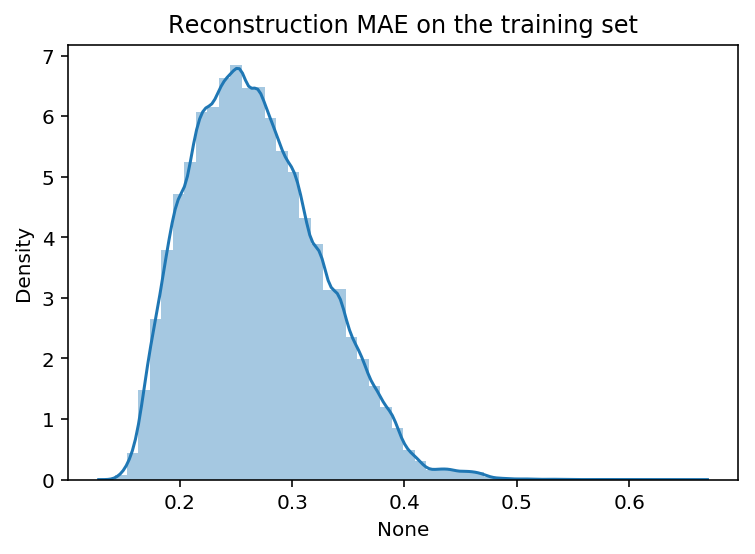

In [48]:
# Reconstruction loss on the train set
train_y, train_mae_loss = [], []

for X, y in test_generator(256, train_paths, train_labels, 100, 25):
    train_y.append(y)
    reconst_X = model.predict(X)
    train_mae_loss.append(np.mean(np.abs(reconst_X - X), axis=(1, 2)))

train_y = np.concatenate(train_y)
train_mae_loss = np.concatenate(train_mae_loss)

# Plot mae of training set reconstruction
sns.distplot(train_mae_loss).set_title('Reconstruction MAE on the training set')

In [69]:
# Set a threshold based on the test set reconstruction loss plot
THRESHOLD = np.percentile(train_mae_loss, 95)
THRESHOLD

0.3703135624527931

/projects/d19a8e8b-8443-4e4b-86b0-93ceef78058e/.sage/local/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5,1,'Reconstruction MAE on the test set')

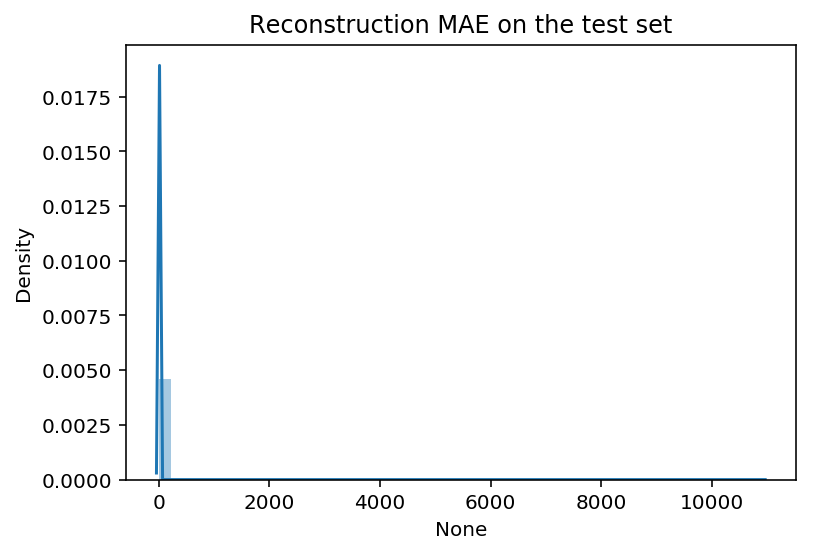

In [66]:
# Reconstruction loss on the train set
test_y, test_mae_loss = [], []

for X, y in test_generator(256, test_paths, test_labels, 100, 25):
    test_y.append(y)
    reconst_X = model.predict(X)
    test_mae_loss.append(np.mean(np.abs(reconst_X - X), axis=(1, 2)))

test_y = np.concatenate(test_y)
test_mae_loss = np.concatenate(test_mae_loss)

# Plot mae of training set reconstruction
sns.distplot(test_mae_loss).set_title('Reconstruction MAE on the test set')

In [70]:
# Threshold test set losses to assign labels (1: anomaly/fail, 0: normal)
pred_y = test_mae_loss
pred_y[pred_y >= THRESHOLD] = 1
pred_y[pred_y < THRESHOLD] = 0

# Accuracy, precision, recall, F1 score
acc = accuracy_score(test_y, pred_y)
print('Accuracy on test set: {:.3f}'.format(acc))

print(classification_report(test_y, pred_y))

Accuracy on test set: 0.713
              precision    recall  f1-score   support

           0       0.64      0.96      0.77     18000
           1       0.91      0.47      0.62     17840

    accuracy                           0.71     35840
   macro avg       0.78      0.71      0.69     35840
weighted avg       0.78      0.71      0.69     35840

